In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [210]:
#mode_name = feed_mode + '_' + str(softmax_temperature) + '_' + reinforce_strategy + '_' + attention_mode

mode_names = [
    'sampling__none_fixed',
    'teacher-forcing___fixed',
    #'sampling__direct_fixed',
    'sampling__argmax_advantage_fixed',
    'soft-gumbel_1.0__fixed'
]

names = ['train_losses', 'eval_losses', 'eval_f1s']

infixes = ['', '_noisy']

suffixes = ['_mean', '_std', '']

In [211]:
import pickle

data = {}
for mode_name in mode_names:
    data[mode_name] = {}
    for name in names:
        for infix in infixes:
            if name == 'train_losses' and infix == '_noisy':
                continue
            data[mode_name][name + infix] = {}
            for suffix in suffixes:
                with open(mode_name + '/' + name + infix + suffix + '.dat', 'rb') as f:
                    data[mode_name][name + infix][suffix] = pickle.load(f)

In [188]:
def exp_running_average(a, alpha=0.95):
    av = np.zeros_like(a)
    av[0] = a[0]
    for i in range(1, len(a)):
        av[i] = alpha * av[i - 1] + (1 - alpha) * a[i]
    return av

In [222]:
print('sampling__argmax_advantage_fixed', np.array(data['sampling__argmax_advantage_fixed']['eval_f1s'][''])[:, 100])
print('teacher-forcing___fixed', np.array(data['teacher-forcing___fixed']['eval_f1s'][''])[:, 100])

sampling__argmax_advantage_fixed [ 72.18  68.75  71.52  69.1   71.23  70.75  71.01  72.46  68.82  72.76]
teacher-forcing___fixed [ 72.64  70.37  72.97  72.18  74.86  73.02  70.69  72.36  72.02  73.45]


In [226]:
from scipy.stats import ttest_ind

ttest_ind(
    np.array(data['sampling__argmax_advantage_fixed']['eval_f1s'][''])[:, 100],
    np.array(data['teacher-forcing___fixed']['eval_f1s'][''])[:, 100],
    equal_var=False
)

Ttest_indResult(statistic=-2.5494302215828046, pvalue=0.020339055252287592)

In [228]:
eval_skip = 10

for mode_name in mode_names:
    print(mode_name)
    for name in names:
        for infix in infixes:
            if name == 'train_losses' and infix == '_noisy':
                continue
            step = 1000
            beta = 0.05
            if name not in ['train_losses', 'train_f1s']:
                step //= eval_skip
                #beta *= eval_skip
            print('{}: {:.3f} +- {:.3f} ({:.3f} -:- {:.3f}) p-value: {:.2f}'.format(
                name + infix,
                exp_running_average(data[mode_name][name + infix]['_mean'], alpha=1-beta)[step],
                exp_running_average(data[mode_name][name + infix]['_std'], alpha=1-beta)[step],
                exp_running_average(np.min(data[mode_name][name + infix][''], axis=0), alpha=1-beta)[step],
                exp_running_average(np.max(data[mode_name][name + infix][''], axis=0), alpha=1-beta)[step],
                ttest_ind(
                    np.array(data[mode_name][name + infix][''])[:, step],
                    np.array(data['sampling__none_fixed'][name + infix][''])[:, step],
                    equal_var=False
                ).pvalue
            ))
    print()

sampling__none_fixed
train_losses: 0.025 +- 0.011 (0.011 -:- 0.048) p-value: 1.00
eval_losses: 0.167 +- 0.010 (0.151 -:- 0.183) p-value: 1.00
eval_losses_noisy: 0.167 +- 0.010 (0.151 -:- 0.183) p-value: 1.00
eval_f1s: 67.652 +- 1.695 (64.871 -:- 70.547) p-value: 1.00
eval_f1s_noisy: 67.315 +- 1.728 (64.438 -:- 70.206) p-value: 1.00

teacher-forcing___fixed
train_losses: 0.018 +- 0.008 (0.007 -:- 0.033) p-value: 0.08
eval_losses: 0.184 +- 0.012 (0.163 -:- 0.205) p-value: 0.01
eval_losses_noisy: 0.215 +- 0.015 (0.188 -:- 0.240) p-value: 0.00
eval_f1s: 69.849 +- 1.551 (67.310 -:- 72.445) p-value: 0.02
eval_f1s_noisy: 55.164 +- 2.679 (50.237 -:- 59.673) p-value: 0.00

sampling__argmax_advantage_fixed
train_losses: 0.027 +- 0.011 (0.012 -:- 0.049) p-value: 0.66
eval_losses: 0.167 +- 0.010 (0.150 -:- 0.185) p-value: 0.86
eval_losses_noisy: 0.167 +- 0.010 (0.151 -:- 0.185) p-value: 0.87
eval_f1s: 67.665 +- 1.893 (64.104 -:- 70.402) p-value: 0.96
eval_f1s_noisy: 67.321 +- 1.926 (63.597 -:- 70.

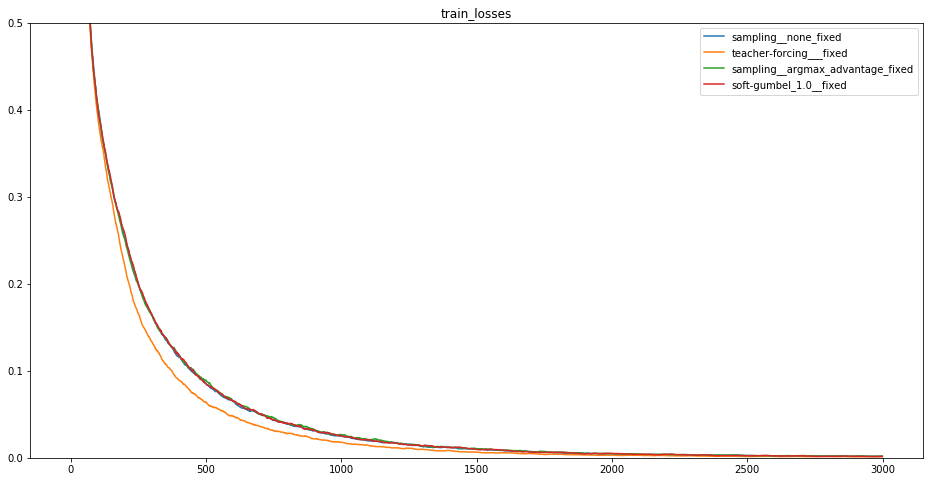

In [208]:
plt.figure(figsize=(16, 8))

name = 'train_losses'
for mode_name in mode_names:
    for infix in ['']:
        plt.plot(exp_running_average(data[mode_name][name + infix]['_mean'], 0.95))
        #plt.fill_between(
        #    range(len(data[mode_name][name + infix]['_mean'])),
        #    exp_running_average(data[mode_name][name + infix]['_mean'] - data[mode_name][name + infix]['_std']),
        #    exp_running_average(data[mode_name][name + infix]['_mean'] + data[mode_name][name + infix]['_std']),
        #    alpha=0.5
        #)
plt.ylim(0, 0.5)
plt.legend([mode_name for mode_name in mode_names])
plt.title(name)

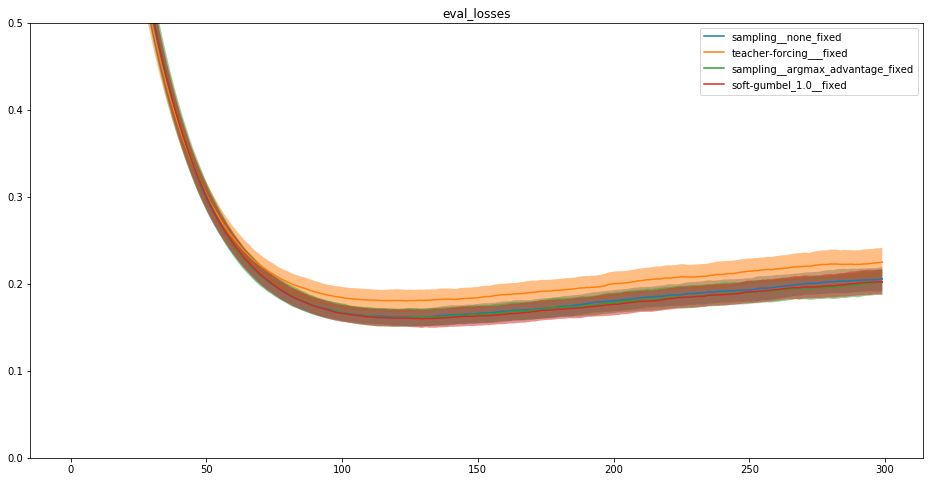

In [213]:
plt.figure(figsize=(16, 8))

name = 'eval_losses'
for mode_name in mode_names:
    for infix in ['']:
        plt.plot(exp_running_average(data[mode_name][name + infix]['_mean'], alpha=0.95))
        plt.fill_between(
            range(len(data[mode_name][name + infix]['_mean'])),
            exp_running_average(data[mode_name][name + infix]['_mean'] - data[mode_name][name + infix]['_std']),
            exp_running_average(data[mode_name][name + infix]['_mean'] + data[mode_name][name + infix]['_std']),
        #    exp_running_average(np.min(data[mode_name][name + infix][''], axis=0)),
        #    exp_running_average(np.max(data[mode_name][name + infix][''], axis=0)),
            alpha=0.5
        )
plt.ylim(0, 0.5)
plt.legend([mode_name for mode_name in mode_names])
plt.title(name)

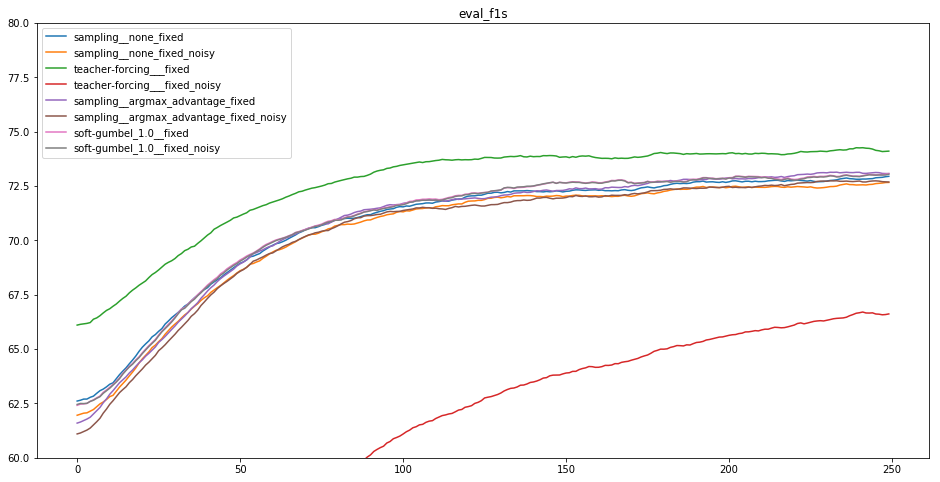

In [190]:
plt.figure(figsize=(16, 8))

name = 'eval_f1s'
for mode_name in mode_names:
    for infix in infixes:
        plt.plot(exp_running_average(data[mode_name][name + infix]['_mean'][50:]))
        #plt.fill_between(
        #    range(len(data[mode_name][name + infix]['_mean'])),
        #    exp_running_average(data[mode_name][name + infix]['_mean'] - data[mode_name][name + infix]['_std']),
        #    exp_running_average(data[mode_name][name + infix]['_mean'] + data[mode_name][name + infix]['_std']),
        #    alpha=0.5
        #)
plt.ylim(60, 80)
plt.legend([mode_name + infix for mode_name in mode_names for infix in infixes])
plt.title(name)

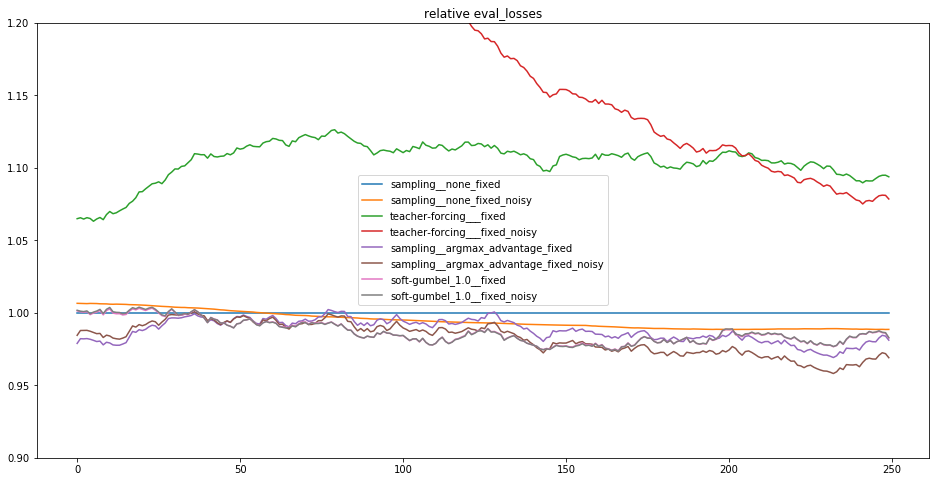

In [193]:
plt.figure(figsize=(16, 8))

name = 'eval_losses'
for mode_name in mode_names:
    for infix in infixes:
        plt.plot(
            exp_running_average(
                (data[mode_name][name + infix]['_mean'] / (data['sampling__none_fixed'][name]['_mean'] + 1e-20))[50:],
            )
        )
        #plt.fill_between(
        #    range(250),
        #    exp_running_average(
        #        ((data[mode_name][name + infix]['_mean'] - data[mode_name][name + infix]['_std']) / (data['sampling__none_fixed'][name]['_mean'] + 1e-20))[50:]
        #    ),
        #    exp_running_average(
        #        ((data[mode_name][name + infix]['_mean'] + data[mode_name][name + infix]['_std']) / (data['sampling__none_fixed'][name]['_mean'] + 1e-20))[50:]
        #    ),
        #    alpha=0.5
        #)
plt.legend([mode_name + infix for mode_name in mode_names for infix in infixes])
plt.ylim(0.9, 1.2)
plt.title('relative eval_losses')

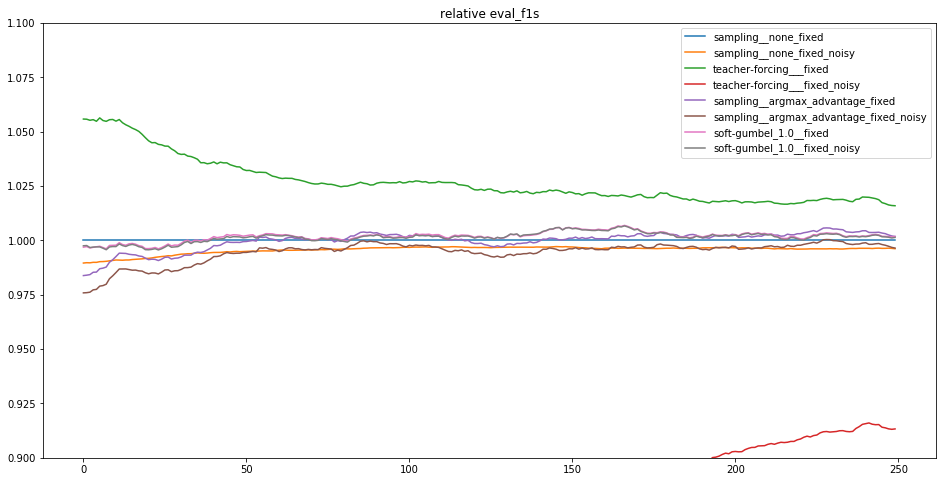

In [195]:
plt.figure(figsize=(16, 8))

name = 'eval_f1s'
for mode_name in mode_names:
    for infix in infixes:
        plt.plot(
            exp_running_average(
                (data[mode_name][name + infix]['_mean'] / (data['sampling__none_fixed'][name]['_mean'] + 1e-20))[50:],
            )
        )
        #plt.fill_between(
        #    range(250),
        #    exp_running_average(
        #        ((data[mode_name][name + infix]['_mean'] - data[mode_name][name + infix]['_std']) / (data['sampling__none_fixed'][name]['_mean'] + 1e-20))[50:]
        #    ),
        #    exp_running_average(
        #        ((data[mode_name][name + infix]['_mean'] + data[mode_name][name + infix]['_std']) / (data['sampling__none_fixed'][name]['_mean'] + 1e-20))[50:]
        #    ),
        #    alpha=0.5
        #)
plt.legend([mode_name + infix for mode_name in mode_names for infix in infixes])
plt.ylim(0.9, 1.1)
plt.title('relative eval_f1s')

In [140]:
np.argmin(exp_running_average(data['sampling__none_fixed']['eval_losses']['_mean'][50:]))

53

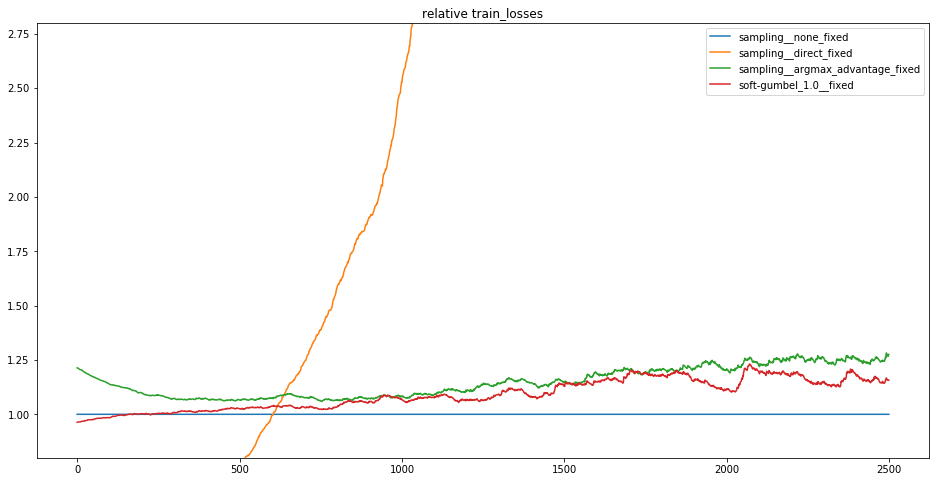

In [141]:
plt.figure(figsize=(16, 8))

name = 'train_losses'
for mode_name in mode_names:
    for infix in ['']:
        plt.plot(
            exp_running_average(
                (data[mode_name][name + infix]['_mean'] / (data['sampling__none_fixed'][name]['_mean'] + 1e-20))[500:],
                alpha=0.995
            )
        )
        #plt.fill_between(
        #    range(250),
        #    exp_running_average(
        #        ((data[mode_name][name + infix]['_mean'] - data[mode_name][name + infix]['_std']) / (data['sampling__none_fixed'][name]['_mean'] + 1e-20))[50:]
        #    ),
        #    exp_running_average(
        #        ((data[mode_name][name + infix]['_mean'] + data[mode_name][name + infix]['_std']) / (data['sampling__none_fixed'][name]['_mean'] + 1e-20))[50:]
        #    ),
        #    alpha=0.5
        #)
plt.legend([mode_name for mode_name in mode_names])
plt.ylim(0.8, 2.8)
plt.title('relative train_losses')

In [169]:
mode_name = 'sampling__direct_fixed'
with open(mode_name + '/av_advantage.dat', 'rb') as f:
    av_advantage = pickle.load(f)
with open(mode_name + '/std_advantage.dat', 'rb') as f:
    std_advantage = pickle.load(f)
with open(mode_name + '/train_f1s_mean.dat', 'rb') as f:
    train_f1s_mean_direct = pickle.load(f)
with open(mode_name + '/train_f1s_std.dat', 'rb') as f:
    train_f1s_std_direct = pickle.load(f)
with open('sampling__none_fixed_large_batch' + '/train_f1s_mean.dat', 'rb') as f:
    train_f1s_mean = pickle.load(f)
with open('sampling__none_fixed_large_batch' + '/train_f1s_std.dat', 'rb') as f:
    train_f1s_std = pickle.load(f)

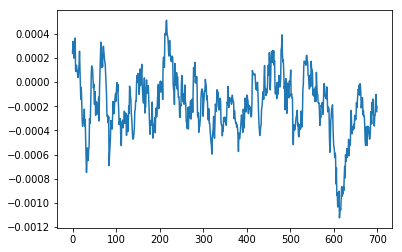

In [174]:
#plt.plot(av_advantage)
plt.plot(exp_running_average(av_advantage, alpha=0.9))

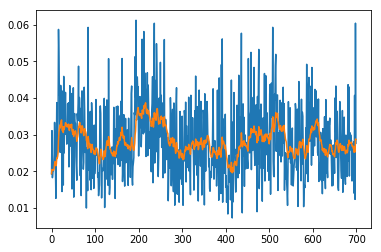

In [173]:
plt.plot(std_advantage)
plt.plot(exp_running_average(std_advantage, alpha=0.9))

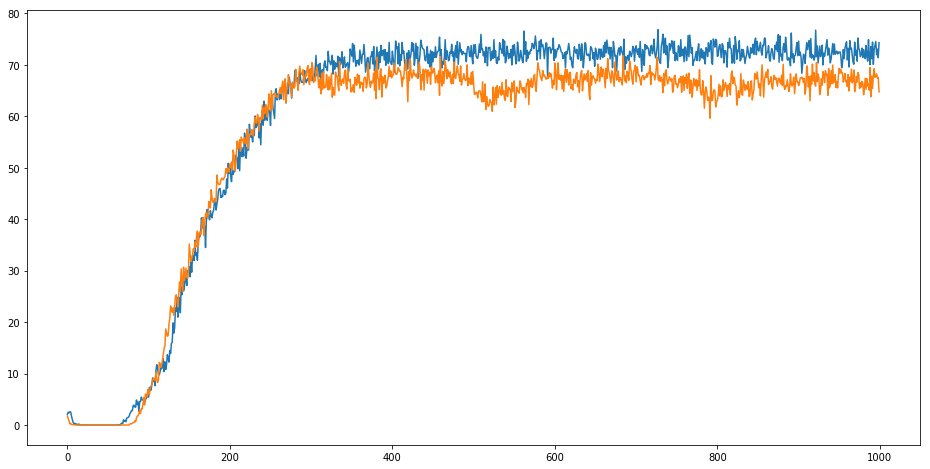

In [171]:
plt.figure(figsize=(16, 8))
plt.plot(train_f1s_mean)
plt.plot(train_f1s_mean_direct)